In [1]:
! nvidia-smi

Tue Nov  1 19:41:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download ja_core_news_sm
!python -m spacy download fi_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 11.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 863 kB/s 
     |████████████████████████████████| 2.2 MB 14.9 MB/s 
  Created wheel for sudachidict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574782 sha256=b0826a2b7bad1c7a28c433bbeb7386772e5ab53f87d4c97192f1a3f7e3e8879f
  Stored in directory: /root/.cache/pip/wheels/66/a9/e1/bde612c31f0ae6877e7e39f278076befd399c488cba80292b6
Successfully built sudachidict-core
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |

In [5]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 5.5 MB 63.8 MB/s 
     |████████████████████████████████| 1.3 MB 38.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=68709c60e2652405dc1b2a19e71b59b97adc0a19d2b6cb3e343ba4753386d552
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [6]:
import gensim
import torchtext
import spacy
import torch.utils.data as Data
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from matplotlib import pyplot as plt
from collections import OrderedDict
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(123)

In [7]:
# epochs
epochs = 100
# batch size
batch_size = 128
# learning rate
lr = 0.0001


# model parameters
input_dim = 384
hidden_dim = 256
output_dim = 2

vocab = False
language_train = ["english"]
language_val = ["english"]
model_type = "regression"

In [8]:
if vocab:
    if language_train == ["english"]:
        tokenizer = spacy.load("en_core_web_sm")
    elif language_train == ["japanese"]:
        tokenizer = spacy.load("ja_core_news_sm")
    elif language_train == ["finnish"]:
        tokenizer = spacy.load("fi_core_news_sm")
    else:
        print("bow model cant be multilingual")


In [9]:
dataset = load_dataset("copenlu/answerable_tydiqa")
train_set = dataset["train"]
validation_set = dataset["validation"]

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-9ffd3d37cf2899c6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 116067
    })
    validation: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 13325
    })
})

In [10]:
def getLanguageDataSet(data, language):
    def printAndL(x):
        return x["language"] in language
    return data.filter(printAndL)


In [11]:
def build_vocab(dataSet, tokenizer):
    counter = Counter()
    for data in dataSet:
        counter.update([token.text for token in tokenizer(data['document_plaintext'])])
    return Vocab(counter)

In [12]:
def getWord2VecModel(train_dataSet, test_dataSet, tokenizer):
    sentences = []
    keys = ["document_plaintext", "question_text"]
    print("train data to vec:")
    for element in tqdm(train_dataSet):
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])
    print("val data to vec:")
    for element in tqdm(test_dataSet):
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])
    
    w2v_model = gensim.models.Word2Vec(sentences, vector_size=input_dim, min_count=1, window=5, epochs=3)

    return w2v_model

In [13]:
def data_process_vocab(dataSet, w2vModel, tokenizer, tokenPart="document"):
    data = []
    for element in tqdm(dataSet):
        if tokenPart == "document":
            en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["document_plaintext"])]], dtype=torch.float32)
            en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
            data.append(en_tensor_)
        elif tokenPart == "question":
            en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["question_text"])]], dtype=torch.float32)
            en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
            data.append(en_tensor_)
        elif tokenPart == "answer":
            if (element["annotations"]["answer_start"] == [-1]):
                data.append(torch.tensor([0], dtype=torch.int64).cuda())
            else:
                data.append(torch.tensor([1], dtype=torch.int64).cuda())
    return torch.cat(data, dim=0)

def data_process_sentence(dataSet, SbertModel, tokenPart="document"):
    data = []
    for element in tqdm(dataSet):
        if tokenPart == "document":
            en_tensor_ = torch.tensor([SbertModel.encode(element["document_plaintext"])], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "question":
            en_tensor_ = torch.tensor([SbertModel.encode((element["question_text"]))], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "answer":
            if (element["annotations"]["answer_start"] == [-1]):
                data.append(torch.tensor([0], dtype=torch.int64).cuda())
            else:
                data.append(torch.tensor([1], dtype=torch.int64).cuda())
    return torch.cat(data, dim=0)


In [14]:
def getData(data, language):
    print("get data:")
    dataset = getLanguageDataSet(data, language)
    if vocab:
        print("bow model:")
        # englishVocab = build_vocab(dataset, tokenizer)
        model = getWord2VecModel(train_set, validation_set, tokenizer)
        answer_set = data_process_vocab(dataset, model, tokenizer, "answer")
        question_set = data_process_vocab(dataset, model, tokenizer, "question")
        document_set = data_process_vocab(dataset, model, tokenizer, "document")
    else:
        print("sentence model:")
        model = SentenceTransformer('all-MiniLM-L6-v2')
        answer_set = data_process_sentence(dataset, model, "answer")
        question_set = data_process_sentence(dataset, model, "question")
        document_set = data_process_sentence(dataset, model, "document")
    
    return answer_set, question_set, document_set


In [15]:
# train_set
answer_train_set, question_train_set, document_train_set = getData(train_set, language_train)
# val_set
answer_validation_set, question_validation_set, document_validation_set = getData(validation_set, language_val)


get data:


  0%|          | 0/117 [00:00<?, ?ba/s]

sentence model:


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


  0%|          | 0/7389 [00:00<?, ?it/s]

get data:


  0%|          | 0/14 [00:00<?, ?ba/s]

sentence model:


  0%|          | 0/990 [00:00<?, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

In [16]:
# dataloader
torch_dataset = Data.TensorDataset(question_train_set, document_train_set, answer_train_set)
train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=True)


In [17]:
class attention(nn.Module):
    def __init__(self, hidden_dim, attn_drop):
        super(attention, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim, bias=True)
        nn.init.xavier_normal_(self.fc.weight, gain=1.414)

        self.tanh = nn.Tanh()
        self.att = nn.Parameter(torch.empty(size=(1, hidden_dim)), requires_grad=True)
        nn.init.xavier_normal_(self.att.data, gain=1.414)

        self.softmax = nn.Softmax()
        if attn_drop:
            self.attn_drop = nn.Dropout(attn_drop)
        else:
            self.attn_drop = lambda x: x

    def forward(self, embeds):
        beta = []
        attn_curr = self.attn_drop(self.att)
        for embed in embeds:
            sp = self.tanh(self.fc(embed)).mean(dim=0)
            beta.append(attn_curr.matmul(sp.t()))
        beta = torch.cat(beta, dim=-1).view(-1)
        beta = self.softmax(beta)
        #print(ntype+" mp ", beta.data.cpu().numpy())  # semantic attention
        z_mp = 0
        for i in range(len(embeds)):
            z_mp = z_mp+ embeds[i]*beta[i]
        return z_mp


In [18]:
class QA_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_model, self).__init__()
        self.que_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.context_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.output_layer = nn.Linear(hidden_dim,output_dim)
        self.attention_layer = attention(hidden_dim,0.5)

    def forward(self,question,context):
        q_vec = F.leaky_relu(self.que_in_mlp(question))
        c_vec = F.leaky_relu(self.context_in_mlp(context))
        attention_out = self.attention_layer([q_vec,c_vec])
        predict_label = self.output_layer(attention_out)

        return predict_label

class QA_LR_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_LR_model, self).__init__()
        self.input_layer = nn.Linear(input_dim*2,hidden_dim)
        self.relu_0 = nn.ReLU()
        self.hidden_layer_0 = nn.Linear(hidden_dim,hidden_dim*2)
        self.relu_1 = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(hidden_dim*2,hidden_dim)
        self.relu_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim,output_dim)

    def forward(self,data):
        input = self.input_layer(data)
        relu_0 = self.relu_0(input)
        hidden_0 = self.hidden_layer_0(relu_0)
        relu_1 = self.relu_1(hidden_0)
        hidden_1 = self.hidden_layer_1(relu_1)
        relu_2 = self.relu_2(hidden_1)
        output = F.sigmoid(self.output_layer(relu_0))

        return output


In [19]:
if model_type == "regression":
    # LR model define
    model = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')
else:
    # attention model define
    model = QA_model(input_dim, hidden_dim, output_dim).to('cuda')

# show model structure
print(model)


QA_LR_model(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu_0): ReLU()
  (hidden_layer_0): Linear(in_features=256, out_features=512, bias=True)
  (relu_1): ReLU()
  (hidden_layer_1): Linear(in_features=512, out_features=256, bias=True)
  (relu_2): ReLU()
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [20]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0 loss: 0.6911 acc: 0.6666666666666666
epoch: 5 loss: 0.6433 acc: 0.7419354838709677
epoch: 10 loss: 0.5557 acc: 0.7849462365591398
epoch: 15 loss: 0.5292 acc: 0.7634408602150538
epoch: 20 loss: 0.5809 acc: 0.7204301075268817
epoch: 25 loss: 0.5449 acc: 0.8064516129032258
epoch: 30 loss: 0.5167 acc: 0.7849462365591398
epoch: 35 loss: 0.4856 acc: 0.8709677419354839
epoch: 40 loss: 0.533 acc: 0.7634408602150538
epoch: 45 loss: 0.5018 acc: 0.8172043010752689
epoch: 50 loss: 0.5136 acc: 0.8172043010752689
epoch: 55 loss: 0.567 acc: 0.7419354838709677
epoch: 60 loss: 0.5624 acc: 0.7419354838709677
epoch: 65 loss: 0.5248 acc: 0.8064516129032258
epoch: 70 loss: 0.516 acc: 0.8064516129032258
epoch: 75 loss: 0.528 acc: 0.7849462365591398
epoch: 80 loss: 0.4339 acc: 0.9032258064516129
epoch: 85 loss: 0.4904 acc: 0.8172043010752689
epoch: 90 loss: 0.4812 acc: 0.8602150537634409
epoch: 95 loss: 0.545 acc: 0.7204301075268817
max acc: 0.9140625


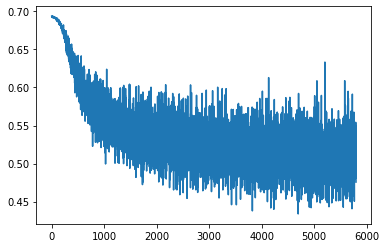

In [21]:
# train
max_acc = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    model.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader:
        if model_type == "regression":
            data = torch.cat((question_vec, document_vec), 1)
            predict_label = model(data)
        else:
            predict_label = model(question_vec, document_vec)
        
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer.zero_grad()
        if (acc > max_acc):
            max_acc = acc
            torch.save(model.state_dict(), 'model.pth')
        loss.backward()
        optimizer.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "loss:", round(loss.item(), 4), "acc:", acc)
print("max acc:", max_acc)

plt.cla()
plt.plot(loss_list)

In [22]:
model.load_state_dict(torch.load("model.pth"))

if model_type == "regression":
    val_input = torch.cat((question_validation_set, document_validation_set), 1)
    predict_label = model(val_input)
else:
    predict_label = model(question_validation_set, document_validation_set)
pred = predict_label.max(-1, keepdim=True)[1]
label = answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

test_acc

0.7454545454545455

In [23]:
report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.776765,0.688889,0.730193,495.000000
1,0.720508,0.802020,0.759082,495.000000
accuracy,0.745455,0.745455,0.745455,0.745455
macro avg,0.748637,0.745455,0.744637,990.000000
weighted avg,0.748637,0.745455,0.744637,990.000000


In [24]:
confusion_matrix(label.cpu(), pred.cpu())

array([[341, 154],
       [ 98, 397]])

In [25]:
parm={}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.to('cpu').detach().numpy()

input_layer.weight : torch.Size([256, 768])
input_layer.bias : torch.Size([256])
hidden_layer_0.weight : torch.Size([512, 256])
hidden_layer_0.bias : torch.Size([512])
hidden_layer_1.weight : torch.Size([256, 512])
hidden_layer_1.bias : torch.Size([256])
output_layer.weight : torch.Size([2, 256])
output_layer.bias : torch.Size([2])


In [26]:
parm['output_layer.weight']

array([[ 0.2176824 , -0.22318839,  0.24150996,  0.20946494, -0.14228685,
        -0.21507864, -0.18116738,  0.15748793, -0.23437414,  0.2551345 ,
         0.18940695, -0.21517709,  0.16347939,  0.19620828, -0.21448971,
         0.20023668, -0.15037388,  0.19409004, -0.24527186,  0.20658004,
        -0.1641325 , -0.17861132, -0.19082318,  0.23362926,  0.17804952,
         0.20403346, -0.23794296, -0.17805162,  0.23496485,  0.22858411,
         0.19806339, -0.15483433, -0.13857812,  0.22514834,  0.18791014,
         0.22161818,  0.19640277, -0.2335576 , -0.22283766,  0.21712537,
         0.15477939, -0.12674387,  0.1850881 ,  0.20824997, -0.17580865,
        -0.2100045 ,  0.13687605,  0.20860003,  0.1486319 , -0.24432823,
        -0.19955203, -0.22289398, -0.20912908, -0.20222764,  0.22996442,
         0.1607214 , -0.13119872,  0.1548143 ,  0.19493948, -0.18906274,
         0.21244276, -0.21925864,  0.16859931, -0.24765238,  0.20493457,
        -0.23348576, -0.22625528, -0.22723731, -0.1

In [27]:
show_train_set = getLanguageDataSet(train_set, language_train)

val_sentences = []
for i in range(len(show_train_set['question_text'])):
    val_sentences.append(show_train_set[i]['question_text'] + " " + show_train_set[i]['document_plaintext'])


In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
features = vectorizer.fit_transform(val_sentences)

0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


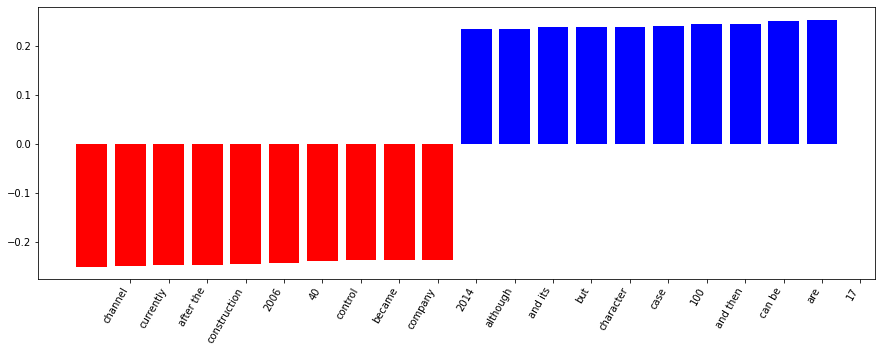

1


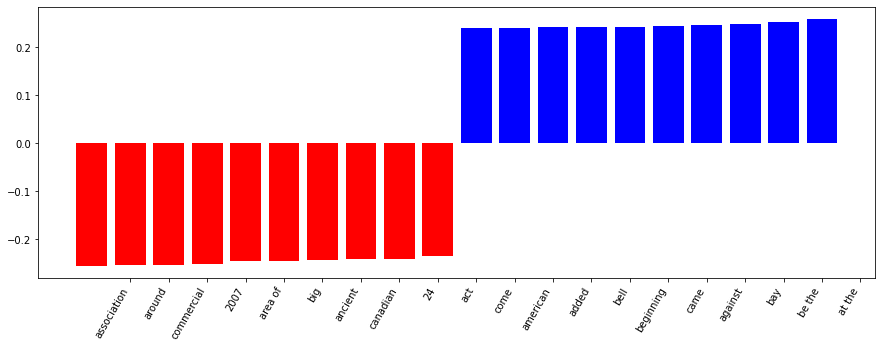

In [29]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = parm['output_layer.weight']

# ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']

for i, cls in enumerate([0, 1]): # for each of the classes
    print(cls)
    # get the weights for the class
    coef = all_class_coef[i]
    # find the top negative and positive features for the class
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    # combine them in one array
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot - humans tend to understand better plot visualizations
    feature_names = vectorizer.get_feature_names()
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()